## Master thesis: Car Sales Forecasting in Finland using Machine Learning

### Loading data

In [1]:
import pandas as pd
import time

# Input filename, path to source files and output filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'
filename = path + 'Retails_ALL_CY11_CY22.xlsx'

start_time = time.time()

# Load files into pandas dataframes
df = pd.concat(pd.read_excel(filename, sheet_name=None), ignore_index=True)

end_time = time.time()
time_elapsed = end_time - start_time 
print('Completed in %f seconds.' % time_elapsed)

Completed in 157.270013 seconds.


In [2]:
df.shape

(465360, 18)

### Preprocessing data

In [3]:
# Clear spaces in cells using strip() function
df['RetailCountry'] = df['RetailCountry'].str.strip()
df['orderNumber'] = df['orderNumber'].str.strip()

In [4]:
# Sort by orderNumber and RetailDate
df.sort_values(by=['orderNumber', 'RetailDate'], inplace=True)

In [5]:
# Remove duplicates by "orderNumber"
df.drop_duplicates(subset=['orderNumber'], keep='last', inplace=True)

In [6]:
df.shape

(440355, 18)

In [7]:
# Get only Finland
df = df[(df['RetailCountry'] == 'FIN')]

In [8]:
df.shape

(76849, 18)

In [9]:
# Remove unnecessary columns
df.drop(['vehOrderClassCode', 'RetailNSC', 'NSCModelGroupCode',
       'ReportingModelGroup', 'FleetCode', 'DealerCodeRetail',
       'orderCreatedDate', 'RetailCountry', 'ModelGroup',
       'EndItem', 'EIColourCode', 'DealerDeliveryAddrNoRetail',
       'FinancialOwnerCategoryCurrent', 'FinancialOwnerCategoryNext',
       'RetailCount', 'Month'], axis=1, inplace=True)

In [10]:
# Convert RetailDate to date
df['RetailDate'] = pd.to_datetime(df['RetailDate'], dayfirst=True).dt.date
# Get year of the ReailDate
df['year'] = pd.DatetimeIndex(df['RetailDate']).year
# Get month of the RetailDate
df['month'] = pd.DatetimeIndex(df['RetailDate']).month

In [11]:
# Preview dataframe
df

,orderNumber,RetailDate,year,month
39789,NNE0103741,2012-01-31,2012,1
5433,NNE0107709,2011-02-28,2011,2
11142,NNE0117276,2011-04-18,2011,4
818,NNE0119938,2011-01-13,2011,1
1642,NNE0122350,2011-01-25,2011,1
...,...,...,...,...
463993,NNE0655294,2022-08-11,2022,8
463051,NNE0655400,2022-07-18,2022,7
463050,NNE0655404,2022-07-29,2022,7
464043,NNE0655791,2022-08-29,2022,8


In [12]:
# Generating index by date, grouping by and counting
df = df.groupby(['year', 'month']).size().reset_index(name='Orders')
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df.drop(['year', 'month'], axis=1, inplace=True)
df = df.set_index("Date")

In [13]:
# Preview dataframe
df

,Orders
Date,
2011-01-01,901
2011-02-01,671
2011-03-01,917
2011-04-01,785
2011-05-01,764
...,...
2022-04-01,316
2022-05-01,224
2022-06-01,231


### Plotting data

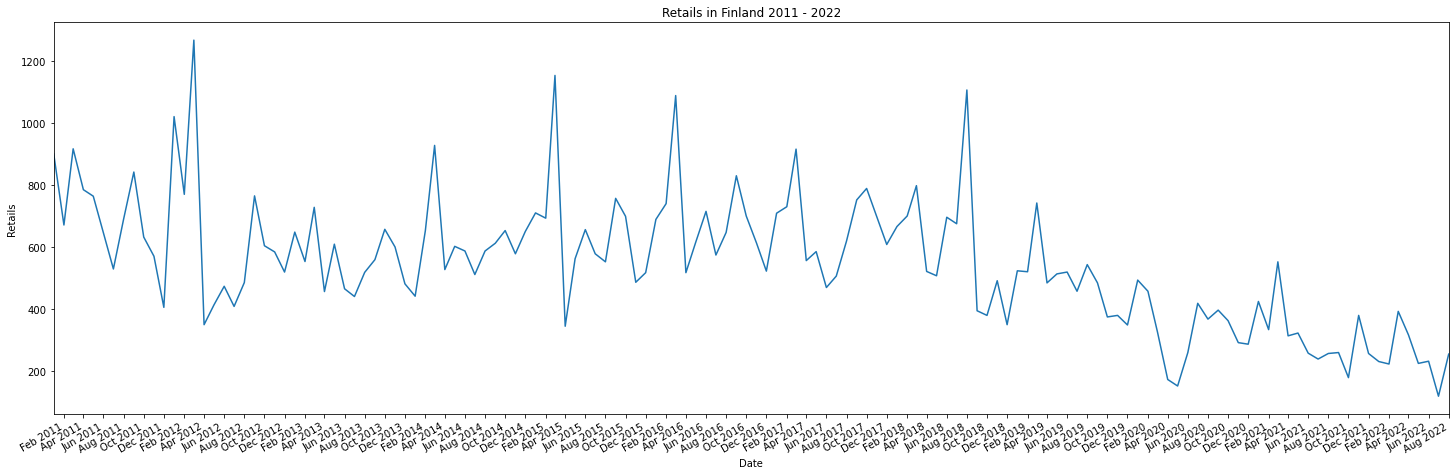

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(25, 8))

half_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m")    # four digits for year, two for month
month_year_formatter = mdates.DateFormatter('%b %Y')    # The "," is intentional.

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(month_year_formatter)

ax.set_xlim([df.index.min(), df.index.max()])
ax.set_title("Retails in Finland 2011 - 2022")
ax.set_xlabel("Date")
ax.set_ylabel("Retails")
ax.plot(df.index, df['Orders'])

fig.autofmt_xdate()

In [16]:
import plotly.graph_objs as go
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df['Orders'], mode='lines+markers', name= 'Test')))
fig.update_layout(title=go.layout.Title(
 text='Monthly Retails 2011–2022',
 xref='paper',x=0),
 margin=dict(l=10, r=0, t=50, b=50),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Year',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Retails',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))))
fig.show()

### Seasonal Trend

In [37]:
import ipywidgets as widgets
import plotly.graph_objs as go

#Generate a widget
widget = widgets.IntRangeSlider(value=[2011, 2022], min=2011, max=2022, step=1, description='Time Period:', 
        disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget

#Prepare Data
years = widget.value
years = list(range(years[0],years[1]+1))
df['Year'] = pd.DatetimeIndex(df.index).year
df['Month'] = [d.strftime('%b') for d in df.index]

#Draw Plot
fig = go.Figure()
for i,y in enumerate(years):
    if i<len(years):
        fig.add_trace(go.Scatter(
            x=df[df['Year']==years[i]].Month.tolist(),
            y=df[df['Year']==years[i]].Orders.round(2).tolist(),
            name=str(years[i])))
fig.update_layout(title=go.layout.Title(
        text="Seasonal Trend of Monthly Retails",
        xref="paper",
        x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Retails",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))
fig.update_yaxes(nticks=10)
   
fig.show()

### Data split

In [39]:
# Select input and target variables
X = df.drop('Orders', axis=1)
y = df["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((112, 2), (28, 2))

### Visualize Train and Test

In [45]:
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=X_train.index, y=y_train, mode='lines+markers', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=X_test.index, y=y_test, mode='lines+markers', name= 'Test')))
fig.update_layout(title=go.layout.Title(
 text='Monthly Retails 2011–2022',
 xref='paper',x=0),
 margin=dict(l=10, r=0, t=50, b=50),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Year',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Retails',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))))
fig.show()

### SEASONAL DECOMPOSITION OF DATA

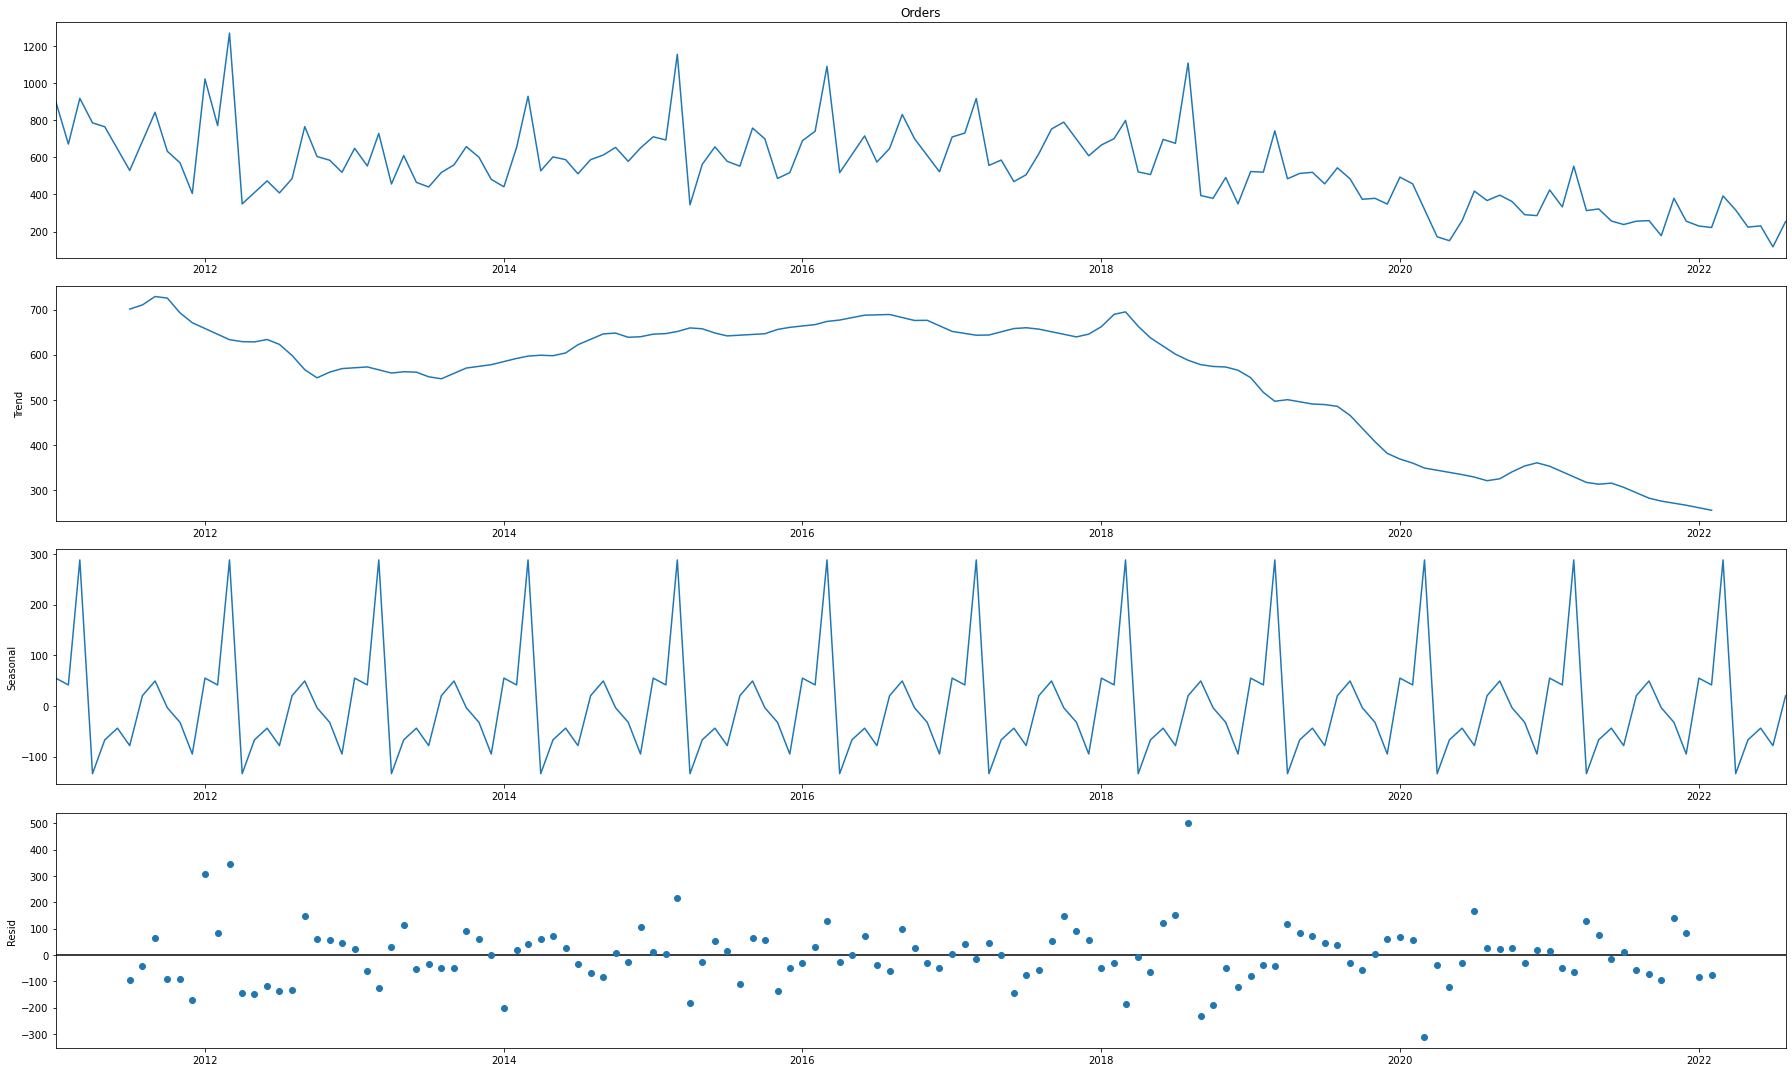

In [35]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Orders.dropna(), model='additive')
result.plot()
plt.show()

 The ‘Seasonal’ graph shows that there exists an evident cyclical trend implying seasonality in the dataset that we’re required to remove before proceeding to modelling.

### Formal checks for Stationarity

Stationary is a very important factor in time series. 

In (S)ARIMA(X) time series forecasting, the first step is to determine the number of differencing required to make the series stationary because a model cannot forecast on non-stationary time series data.

https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

https://medium.com/inflation-forecasting-using-sarimax-and-nkpc/plotting-monthly-inflation-over-the-selected-time-period-to-check-if-the-time-series-has-any-35e3b1fac761

There are two primary ways to determine whether a given time series is stationary or not:

1. Plotting data along with Rolling Average and Rolling Standard Deviation: The time series is stationary if they remain steady with time.
2. Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low (<0.05) and the Test Statistic is lower than the critical values at 1%, 5%, 10% levels of significance.

In [46]:
import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller

# Defining the check for Data Stationarity using Rolling Mean and Rolling Standard Deviation
def TestStationaryPlot(ts):
    
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=df.index, y=ts, mode='lines+markers', name= 'Original Data')))
    fig.add_trace(go.Scatter(dict(x=df.index, y=rol_mean, mode='lines', name= 'Rolling Mean',line=dict(color='black', width=2))))
    fig.add_trace(go.Scatter(dict(x=df.index, y=rol_std, mode='lines', name= 'Rolling Standard',line=dict(color='brown', width=2))))
    fig.update_layout(title=go.layout.Title(
        text="Rolling Mean & Standard Deviation",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))
    fig.show()

# Defining the check for Data Stationarity using Augmented Dickey Fuller(ADF) test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [49]:
TestStationaryPlot(df.Orders)
adf_test(df.Orders)

Results of Dickey-Fuller Test:
Test Statistic                   0.078185
p-value                          0.964540
#Lags Used                      12.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

### DIFFERENCING — ELIMINATING TREND AND SEASONALITY

Seasonal First Difference

In [50]:
Train_seasonal_difference = df.Orders - df.Orders.shift(12)
Train_seasonal_first_difference = Train_seasonal_difference - Train_seasonal_difference.shift(1)
#Plotting and testing the time series for stationarity
TestStationaryPlot(Train_seasonal_first_difference.dropna(inplace=False))
adf_test(Train_seasonal_first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -8.676342e+00
p-value                        4.405798e-14
#Lags Used                     4.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


From the graph we can observe that the rolling mean has now stabilised greatly and the rolling standard deviation has also smoothed out a little indicating that this data set is stationary. The ADF test suggests that the p-value is extremely small and the Test Statistic is less than all the critical values mentioned in the test. This supplements our observation from the graph that we can conclude stationarity of the seasonal first difference Train data.

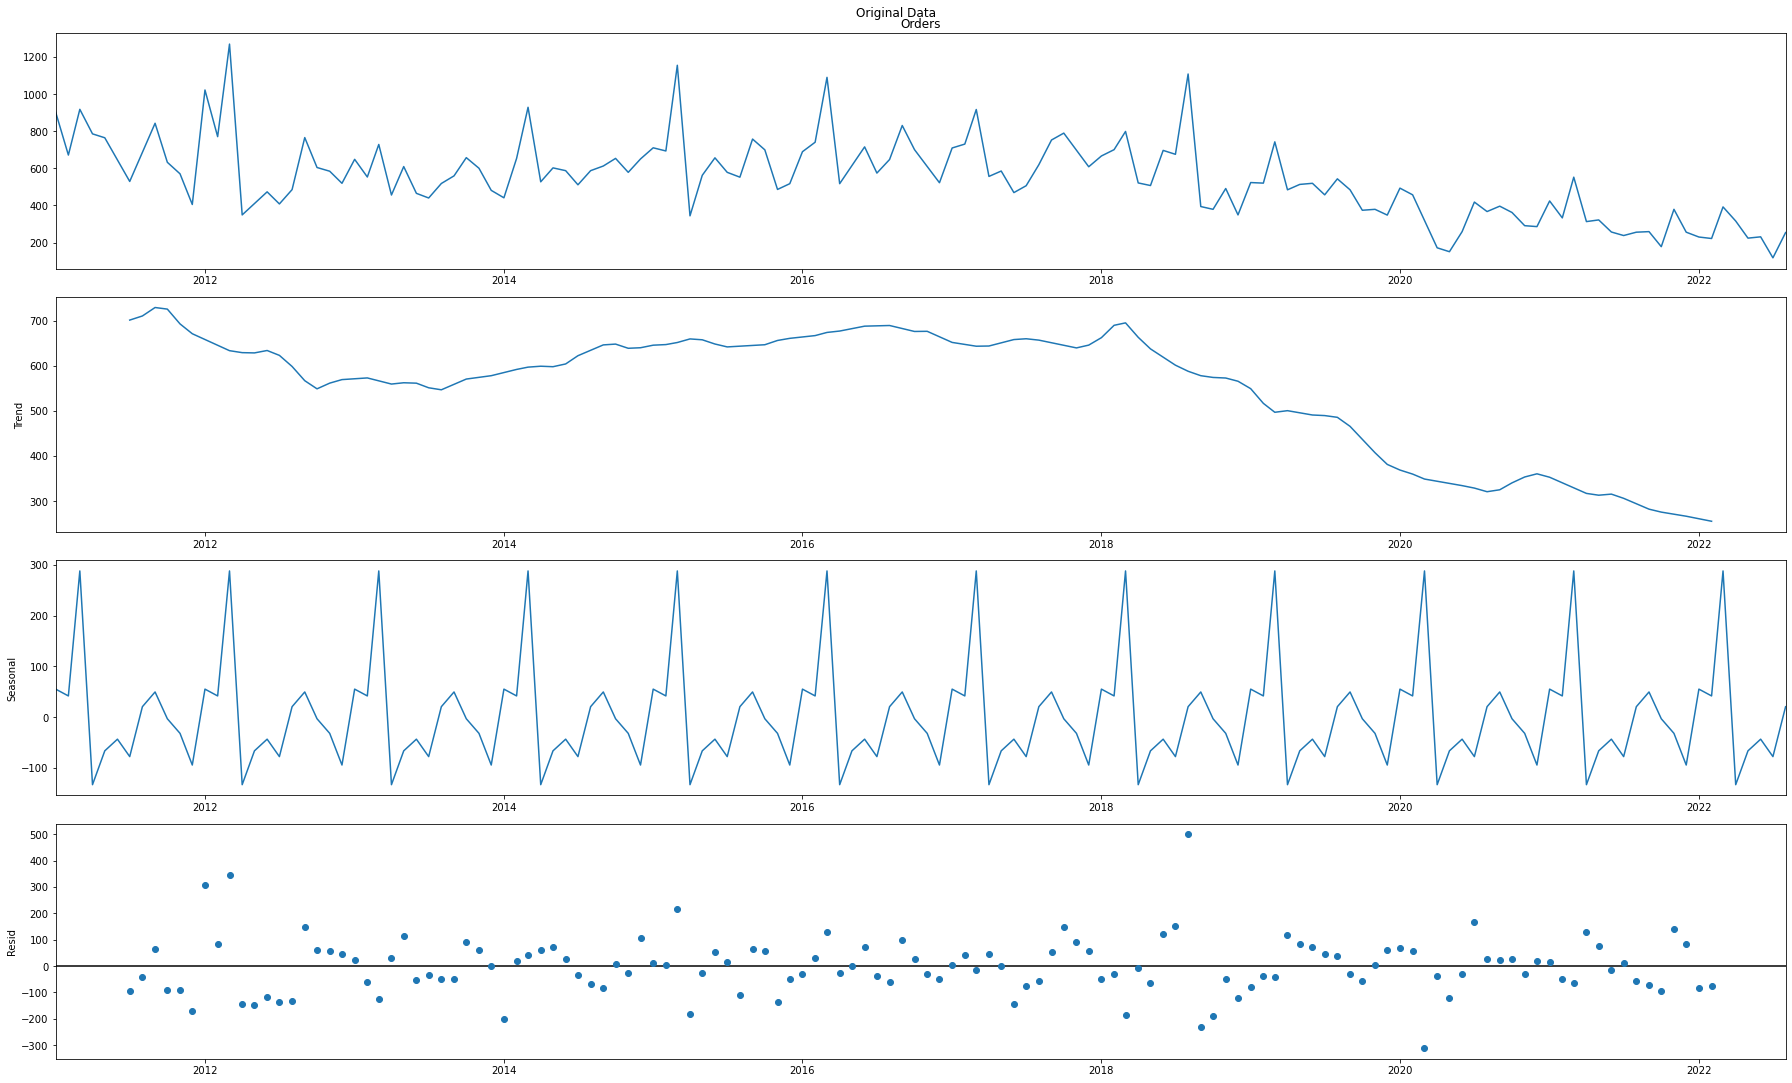

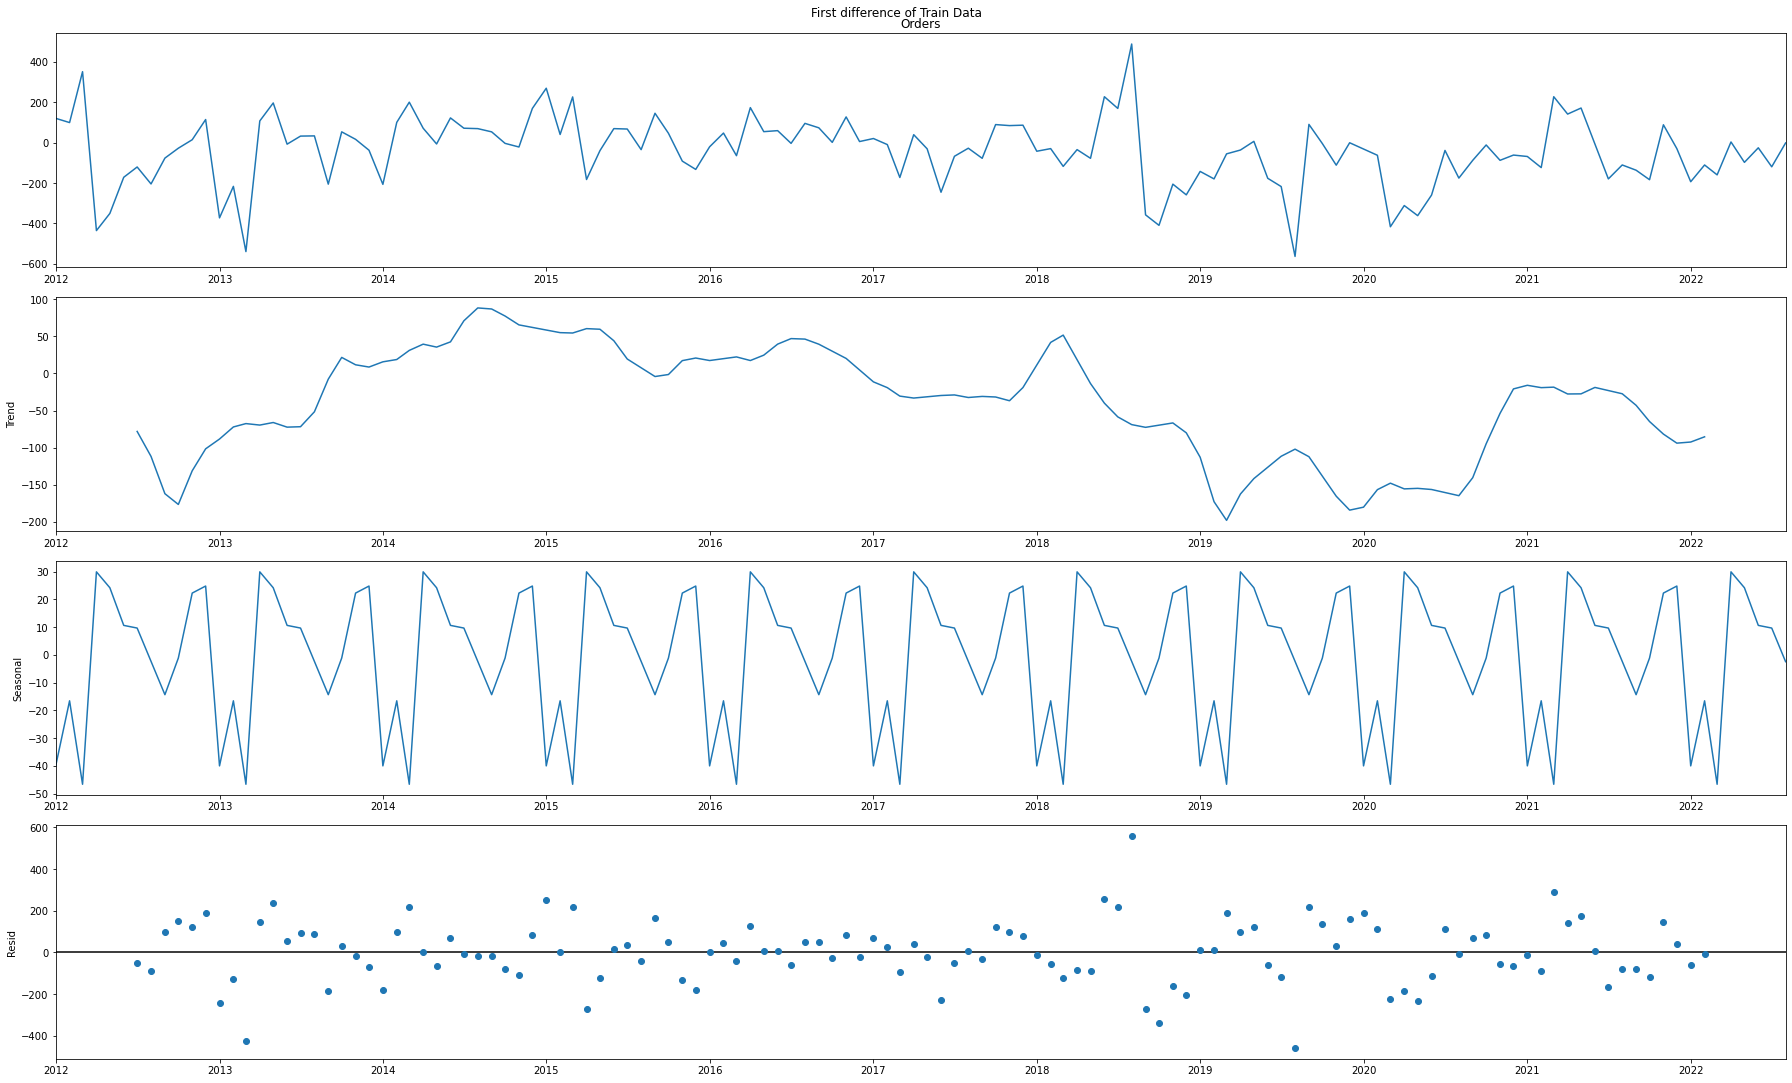

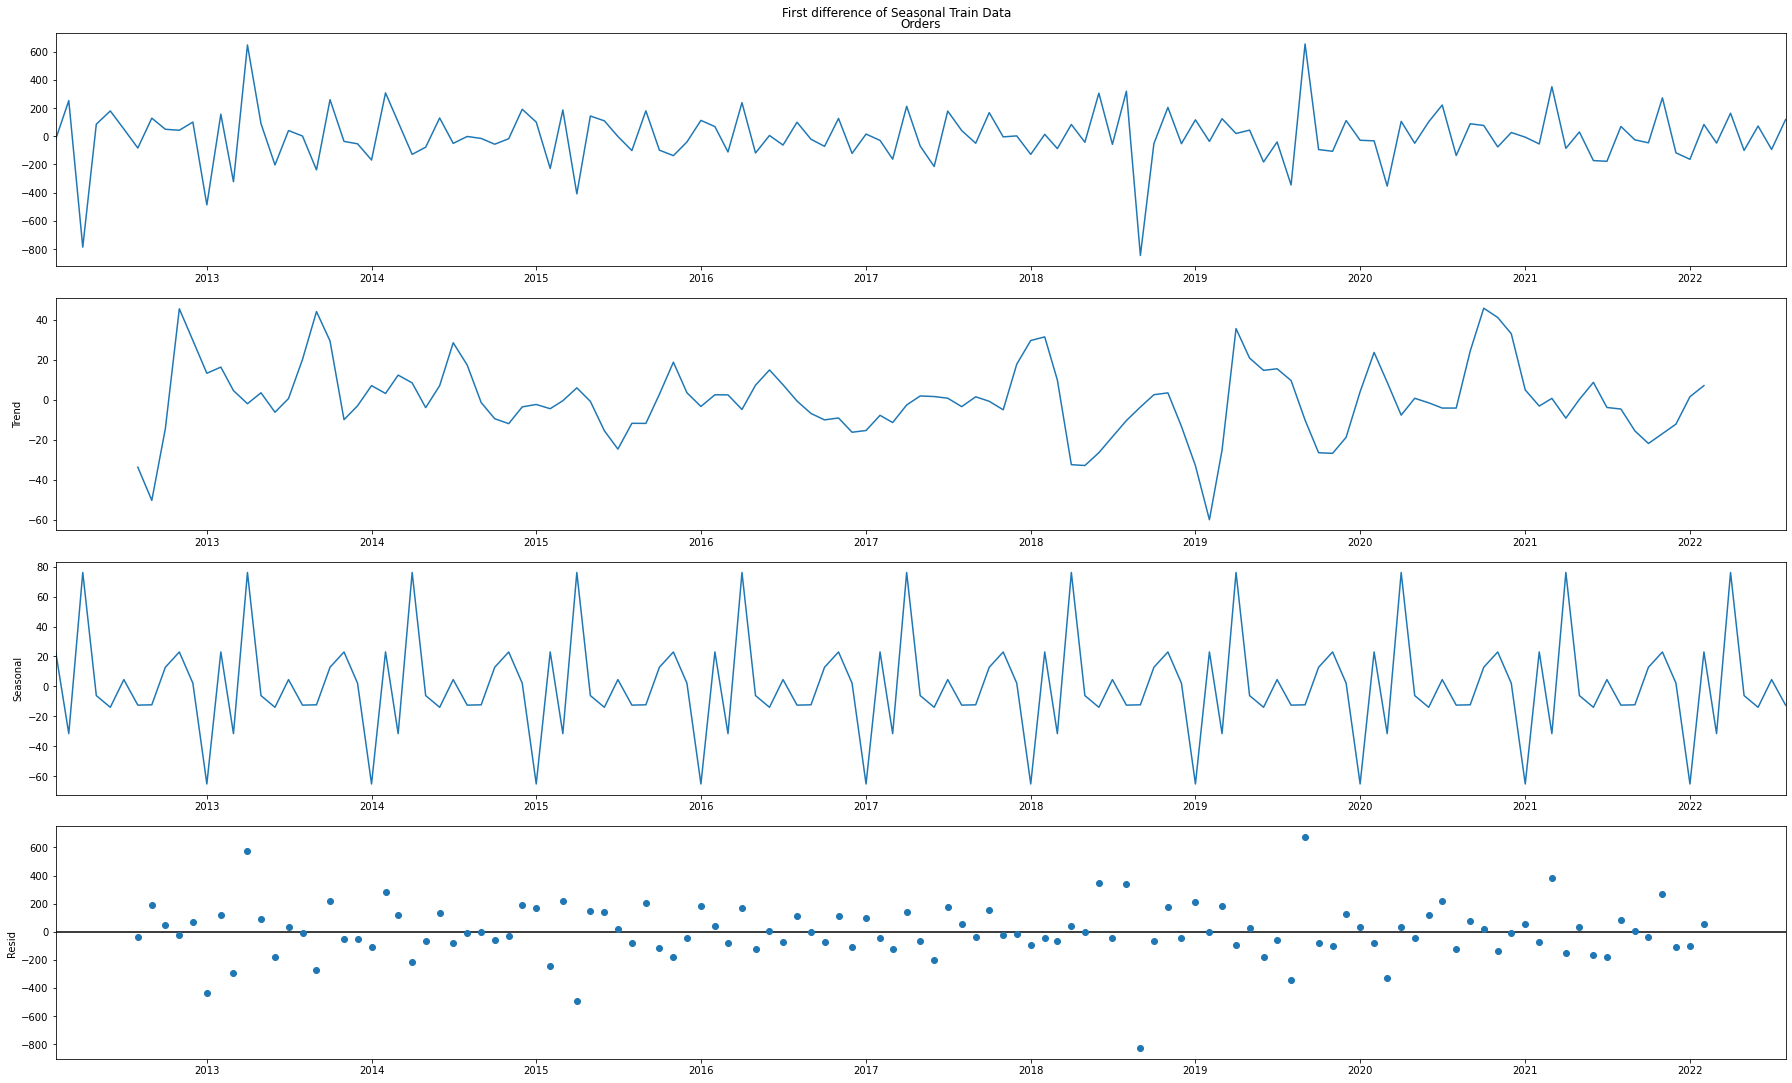

In [55]:
#Seasonal Decomposition
result= seasonal_decompose(df.Orders, model= 'additive')
result.plot()
plt.suptitle('Original Data', y=1)
plt.show()
result1= seasonal_decompose(Train_seasonal_difference.dropna(), model= 'additive')
result1.plot()
plt.suptitle('First difference of Train Data', y=1)
plt.show()
result2=seasonal_decompose(Train_seasonal_first_difference.dropna(), model='additive')
result2.plot()
plt.suptitle('First difference of Seasonal Train Data', y=1)
plt.show()

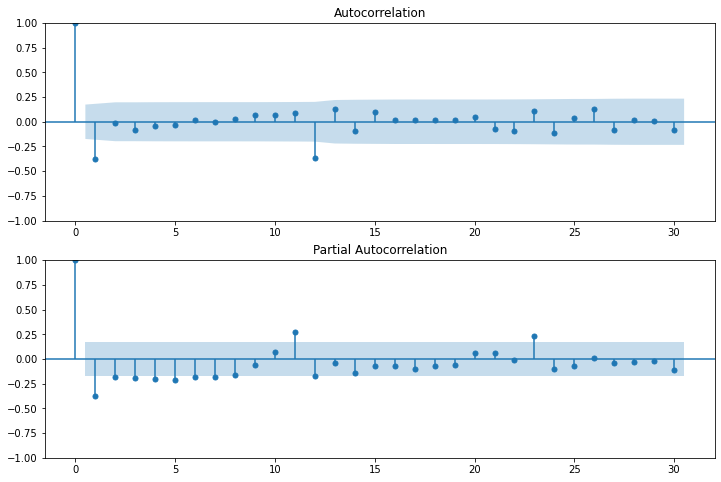

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#Autocorrelation Graph for 40 periods
fig = sm.graphics.tsa.plot_acf(Train_seasonal_first_difference.dropna(), lags=30, ax=ax1)
#Partial autocorrelation Graph for 40 periods
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Train_seasonal_first_difference.dropna(), lags=30, ax=ax2, method='ywm')

### SARIMAX Model

In [78]:
import pandas as pd
import time

# Input filename, path to source files and output filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'
exogenous = path + 'CPI.xlsx'

start_time = time.time()

# Load files into pandas dataframes
df_exo = pd.concat(pd.read_excel(exogenous, sheet_name=None), ignore_index=True)

end_time = time.time()
time_elapsed = end_time - start_time 
print('Completed in %f seconds.' % time_elapsed)

Completed in 0.077992 seconds.


In [79]:
df.reset_index(inplace=	True)

In [81]:
df['Datetime'] = pd.to_datetime(df['Date'])

In [88]:
df

,Orders,Year,Month,Datetime
0,901,2011,Jan,2011-01-01
1,671,2011,Feb,2011-02-01
2,917,2011,Mar,2011-03-01
3,785,2011,Apr,2011-04-01
4,764,2011,May,2011-05-01
...,...,...,...,...
135,316,2022,Apr,2022-04-01
136,224,2022,May,2022-05-01
137,231,2022,Jun,2022-06-01
138,118,2022,Jul,2022-07-01


In [89]:
# Merge both dataframes
data = pd.concat([df,df_exo], axis=1)

In [90]:
data.set_index('Datetime', inplace=True)

In [91]:
data

,Orders,Year,Month,CPI
Datetime,,,,
2011-01-01,901,2011,Jan,101.78
2011-02-01,671,2011,Feb,102.40
2011-03-01,917,2011,Mar,102.96
2011-04-01,785,2011,Apr,103.16
2011-05-01,764,2011,May,103.21
...,...,...,...,...
2022-04-01,316,2022,Apr,121.09
2022-05-01,224,2022,May,122.67
2022-06-01,231,2022,Jun,123.56


In [92]:
data.dtypes

Orders      int64
Year        int64
Month      object
CPI       float64
dtype: object

In [93]:
Train = data[data.index < '2020-05-01']
Valid = data[data.index > '2020-04-01']

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sar = pd.DataFrame(Train["CPI"])
# Introducing a lag of 3 months
sar["CPI_Lagged"] = sar["CPI"].shift(3)
#Solving for NAN values
sar["CPI_Lagged"].fillna(0, inplace = True)
#SARIMAX Model
y_hat_avg = Valid.copy() 
fit1= SARIMAX(Train["Orders"], order=(1, 0, 1),seasonal_order=(1,1,0,12), exog = sar["CPI_Lagged"], 
             trend='ct', simple_differencing=False,enforce_stationarity=False).fit()
print(fit1.summary())

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                      
Dep. Variable:                              Orders   No. Observations:                  112
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                -552.950
Date:                             Wed, 01 Feb 2023   AIC                           1119.900
Time:                                     15:20:59   BIC                           1137.162
Sample:                                 01-01-2011   HQIC                          1126.851
                                      - 04-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5201     21.531      0.163      0.870     -38.680      45.720
drift         -0.1682      

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [105]:
length = Train.shape[0]-1
x = data.loc[length:,"CPI"]
x = x.shift(3)
x.fillna(0, inplace = True)
pred = pd.DataFrame(x)
pred.shape

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [111] of type int

In [104]:
#Preparing Data
start = '2020-05-01'
end = '2022-08-01'
x = data.loc[start:,"CPI"]
x = x.shift(3)
x.fillna(0, inplace = True)
pred = pd.DataFrame(x)
#Predicting inflation
y_hat_avg['SARIMAX'] = fit1.predict(start=start, end=end, dynamic=True, exog = pred)

In [109]:
fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=Train.index, y=Train['Orders'], mode='lines', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=Valid.index, y=Valid['Orders'], mode='lines', name= 'Valid',line=dict(width=2))))
fig.add_trace(go.Scatter(dict(x=Valid.index, y=y_hat_avg['SARIMAX'], mode='lines', name= 'SARIMA',line=dict(width=2))))

fig.update_layout(title=go.layout.Title(
        text="SARIMAX Prediction",
        xref="paper",x=0),
        margin=dict(l=10, r=0, t=50, b=50),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

### Moving average

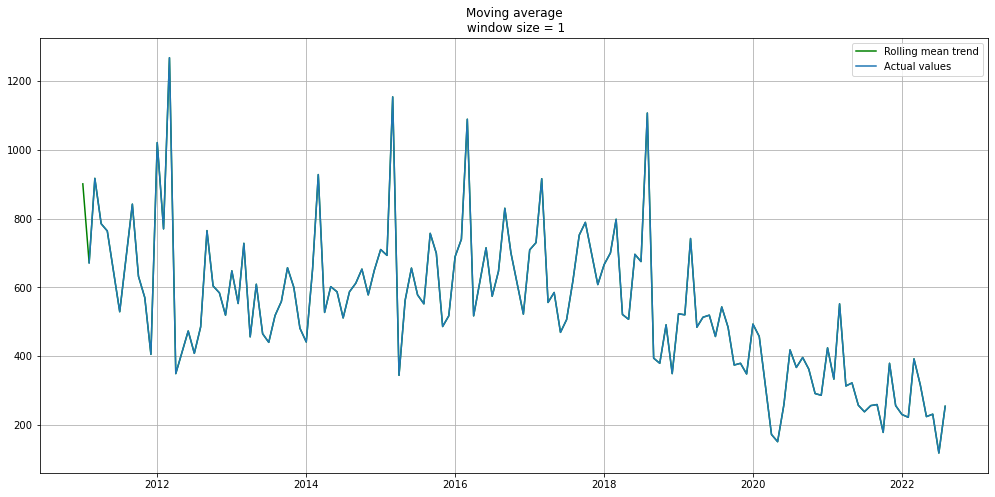

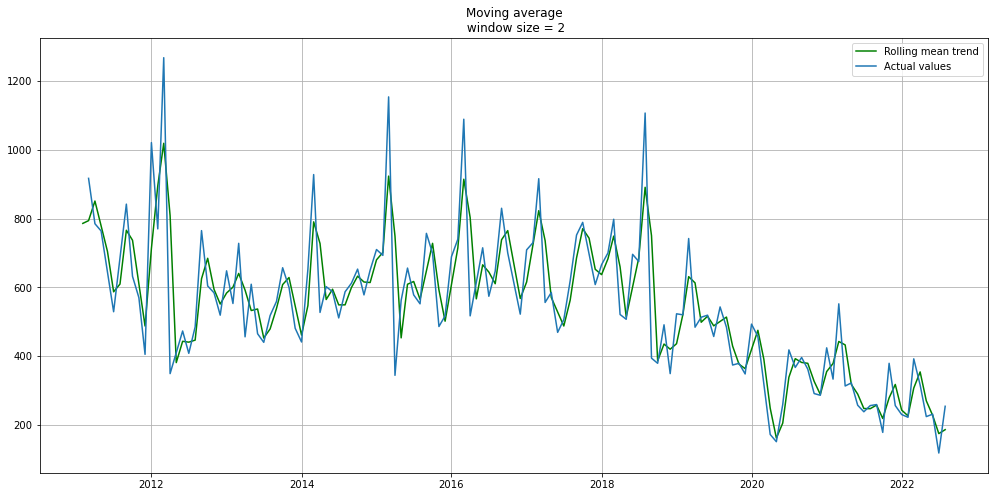

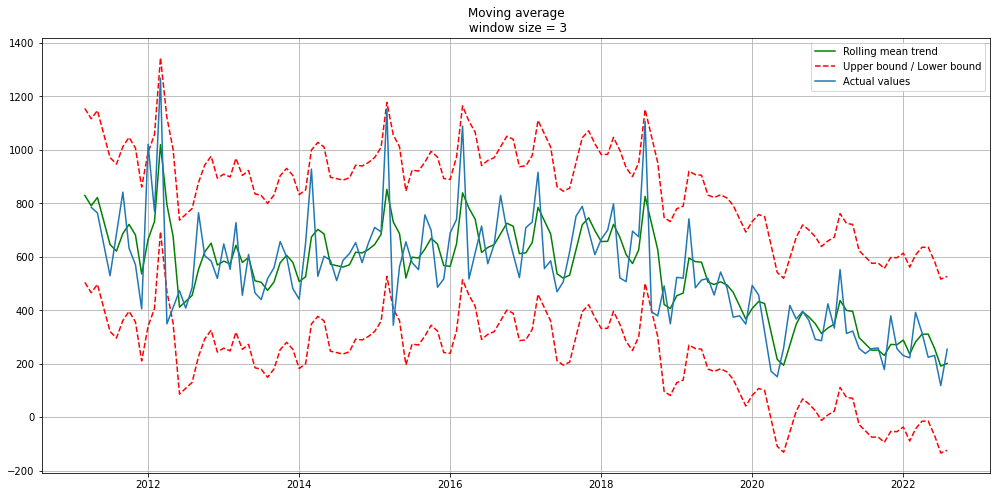

In [20]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(df.Orders, 1)

#Smooth by the previous month (30 days)
plot_moving_average(df.Orders, 2)

#Smooth by previous quarter (90 days)
plot_moving_average(df.Orders, 3, plot_intervals=True)

### Exponential smoothing

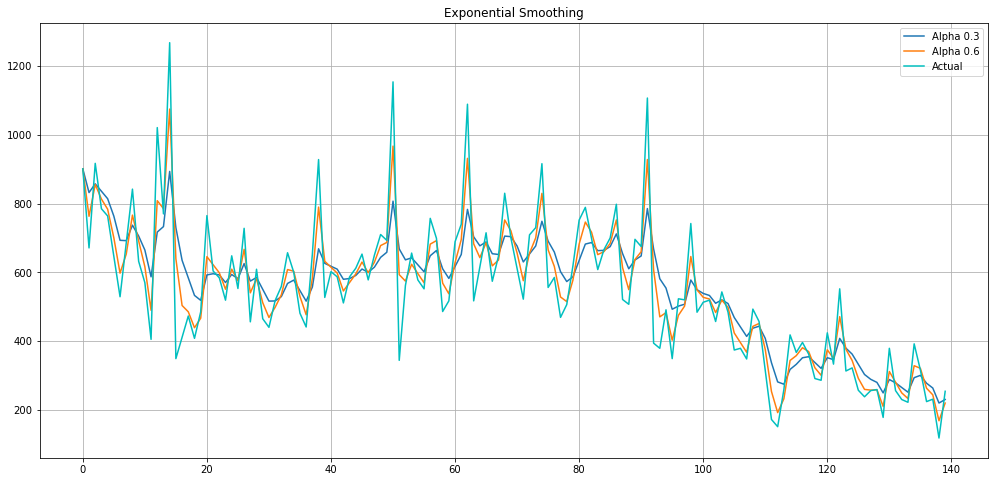

In [23]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(df.Orders, [0.3, 0.6])

### Double exponential smoothing

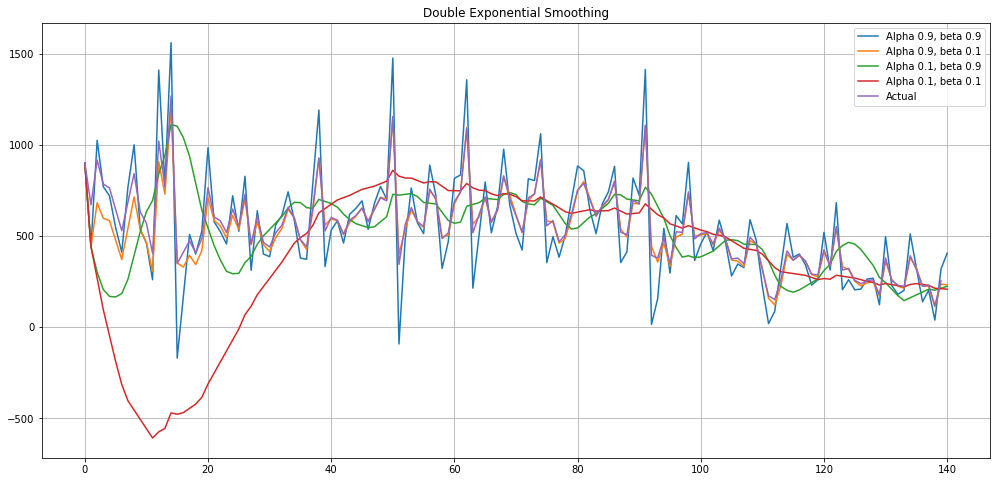

In [25]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df.Orders, alphas=[0.9, 0.1], betas=[0.9, 0.1])

### Modelling
As outlined previously, we must turn our series into a stationary process in order to model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process:

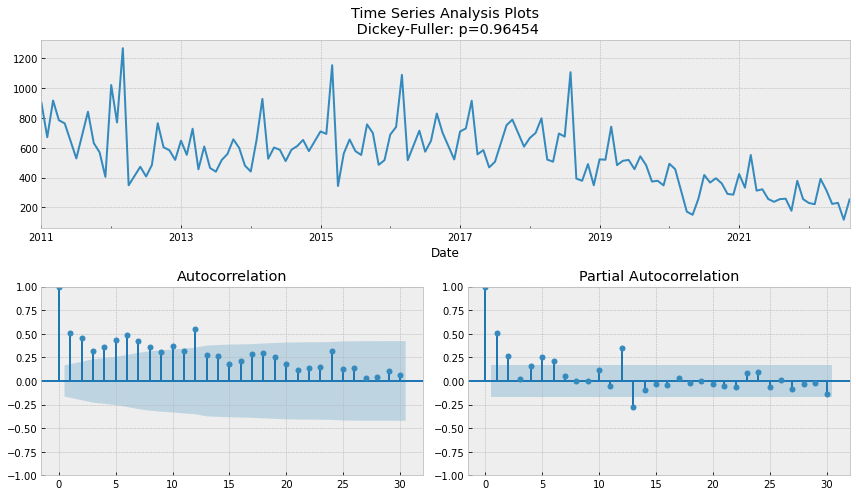

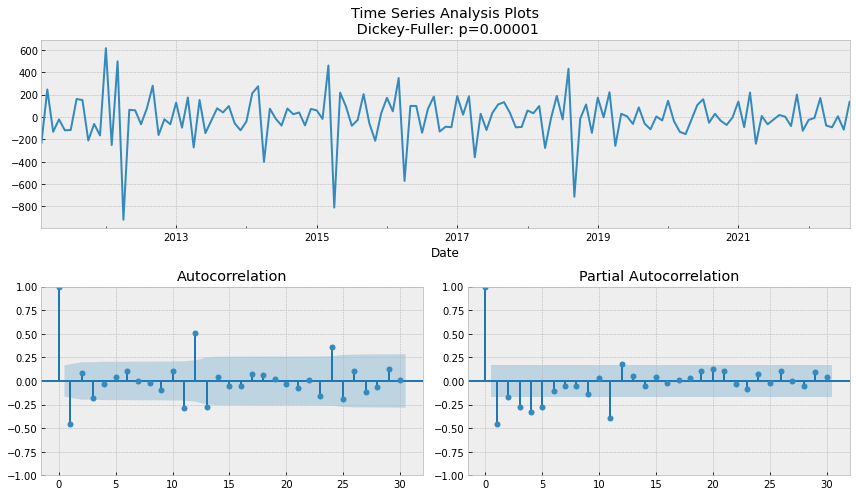

In [30]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
tsplot(df.Orders, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = df.Orders - df.Orders.shift(1)

tsplot(data_diff[1:], lags=30)

### SARIMA

In [31]:
from tqdm.notebook import tqdm
from itertools import product

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm.notebook.tqdm(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.Orders, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.Orders, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

C:\Users\ne74255\AppData\Local\Temp/ipykernel_10004/826130474.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py

                                         SARIMAX Results                                         
Dep. Variable:                                    Orders   No. Observations:                  140
Model:             SARIMAX(1, 1, 0)x(3, 1, [1, 2, 3], 5)   Log Likelihood                   0.000
Date:                                   Wed, 01 Feb 2023   AIC                             16.000
Time:                                           11:49:25   BIC                             39.183
Sample:                                       01-01-2011   HQIC                            25.421
                                            - 08-01-2022                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9472   8.52e-09   1.11e+08      0.000    

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: invalid value encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py